<!-- DON'T EDIT THIS CELL! -->
<!-- TYPE SHIFT+ENTER AND GO TO THE NEXT CELL -->

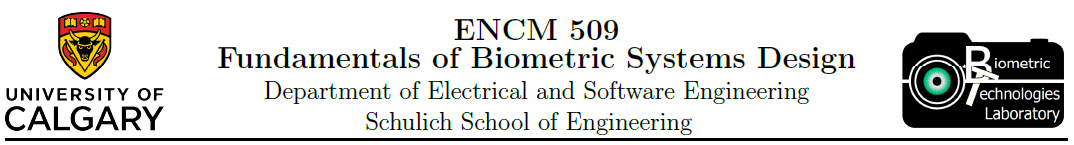

<center>
    <h1>Laboratory Experiment #3</h1>
    <h2>Biometric-based verification: Signature</h2>
</center>

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import pandas as pd
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
import os

## Loading Signatures

In [6]:
# data folder:
# 'signature_samples/biometrics/'
# 'signature_samples/calgary/'
# 'signature_samples/hello/'

# this is the place where the folders "genuine" and "impostor" are
# change it to point to your dataset.
base_dir = os.getcwd() + '/signature_samples/biometrics/'

# note that if your dataset folder is in the same folder as the notebook, 
# you don't need the "../" only "./"
#base_dir = './signature_samples/biometrics/'

# "genuine" and "impostor" sub-directories
dir_authentic = base_dir + 'genuine/'
dir_impostor = base_dir + 'impostor/'

# amount of signatures to be loaded
total_signatures = 30
numForgedSigs = 30

# lists to store the loaded signatures
auth_lst = []
imp_lst = []

# loading 'total_signatures' signatures from both "authentic" and "impostor" 
for i in range(total_signatures):
    # columns: [X, Y, Pressure, Time]
    csv_auth = pd.read_csv(dir_authentic + '%d.csv' % (i+1))
    csv_imp = pd.read_csv(dir_impostor + '%d.csv' % (i+1))

    auth_lst.append(csv_auth.values)
    imp_lst.append(csv_imp.values)

In [7]:
print('Size of the "auth_lst" vector: %d' % (len(auth_lst)))
print('Size of the "imp_lst" vector: %d' % (len(imp_lst)))

Size of the "auth_lst" vector: 30
Size of the "imp_lst" vector: 30


## Classification: selecting subset to train

In [8]:
# number of signature samples to use for training the models
NUMTRAININGPATTERNS = 20

# number of Gaussian mixture components in the GMM
NUMGCOMPONENTS = 20

# usually we don't know the final size of train_set because
# each signature has different number of points. 
# to later on use 'concatenate', is necessary to take the first sample outside the loop
train_set = np.reshape(auth_lst[0], (-1,4))

# this for-loop put all the first "NUMTRAININGPATTERNS" in a huge matrix
# this matrix, stored in the varaible "train_set" will be used for the training
for i in range(1,NUMTRAININGPATTERNS):
    # taking from authentic/genuine
    sample = np.reshape(auth_lst[i], (-1,4))
    train_set = np.concatenate((train_set, sample), axis=0)

In [9]:
print('We will use these data for training the Gaussian Mixture Model')
print('The number of signatures for training is the first %d signatures from the set,' % (NUMTRAININGPATTERNS ))
print('and the number of Gaussian mixture components is %d' % (NUMGCOMPONENTS))

We will use these data for training the Gaussian Mixture Model
The number of signatures for training is the first 20 signatures from the set,
and the number of Gaussian mixture components is 20


### Training with the Gaussian Mixture Model

In [10]:
# Training the GaussianMixture model from Scikit-Learn library
# the .fit(...) will perform the training step using the "train_set" 
gmm = GaussianMixture(n_components=NUMGCOMPONENTS).fit(train_set)

### Testing with the remaining signature samples

In [11]:
# to store all the scores calculated
aScores = []

# going through the remaining signatures after removing the first 20 for training
for i in range(NUMTRAININGPATTERNS, total_signatures):
    # taking from authentic/genuine
    sample =  np.reshape(auth_lst[i], (-1,4))
    # compute the per-sample average log-likelihood of the given data.
    score = gmm.score(sample)
    print('%d: %.4f' % (i, score))
    # add the score calculated to the list aScores
    aScores.append(score)

20: -17.5252
21: -17.0377
22: -16.8239
23: -17.1785
24: -17.2968
25: -17.8396
26: -17.4158
27: -17.1401
28: -16.5025
29: -17.4739


### Testing with the forged (impostor) data

In [12]:
fScores = []
for i in range(numForgedSigs):
    # taking from the impostor
    sample =  np.reshape(imp_lst[i], (-1,4))
    score = gmm.score(sample)
    print('%d: %.4f' % (i, score))
    fScores.append(score)

0: -194.3491
1: -122.5191
2: -128.6041
3: -312.4714
4: -232.4597
5: -202.4228
6: -185.7223
7: -214.3479
8: -242.5443
9: -133.6075
10: -111.9345
11: -195.3226
12: -211.0957
13: -170.1504
14: -391.6955
15: -202.3015
16: -124.5349
17: -201.9247
18: -195.1375
19: -516.2182
20: -141.5231
21: -236.1079
22: -124.2079
23: -164.1681
24: -118.5567
25: -111.0942
26: -122.2079
27: -159.8309
28: -128.8072
29: -423.7241


### Calculating mean and std of the scores

In [13]:
# authentic set
aMu = np.mean(aScores)
aStd = np.std(aScores)

# impostor set
fMu = np.mean(fScores)
fStd = np.std(fScores)

print('Average of authentic scores: %.4f' % (aMu))
print('Average of forgery scores: %.4f' % (fMu))

Average of authentic scores: -17.2234
Average of forgery scores: -200.6531


### Probability Density Function (PDF) for forged and authentic data

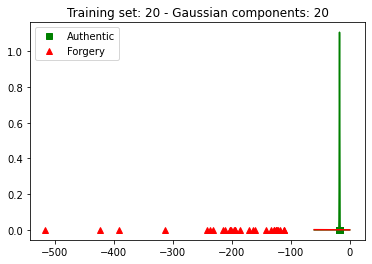

In [14]:
# change this range for your set
x = np.arange(-60, 0, 0.01)

aProb = norm.pdf(x, loc=aMu, scale=aStd)
fProb = norm.pdf(x, loc=fMu, scale=fStd)
plt.plot(x, aProb, 'g')
plt.plot(aScores, np.zeros(len(aScores)), 'gs', lw=2, label='Authentic')
plt.plot(x, fProb, 'r')
plt.plot(fScores, np.zeros(len(fScores)), 'r^', lw=2, label='Forgery')
plt.legend();
plt.title('Training set: {} - Gaussian components: {}'.format(NUMTRAININGPATTERNS, NUMGCOMPONENTS));

#### Based on your data, might be difficult to see the distributions together. Plot in separated images is one solution:

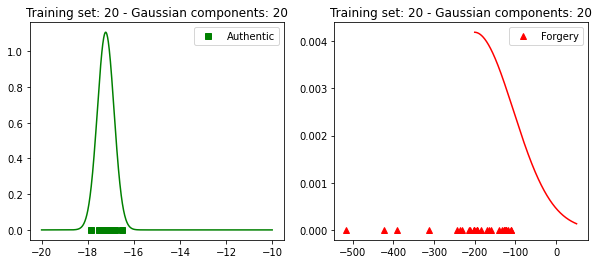

In [15]:
plt.figure(figsize=(10,4))

# Authentic set
x = np.arange(-20, -10, 0.01)
aProb = norm.pdf(x, loc=aMu, scale=aStd)

plt.subplot(1,2,1)
plt.plot(x, aProb, 'g')
plt.plot(aScores, np.zeros(len(aScores)), 'gs', lw=2, label='Authentic')
plt.legend();
plt.title('Training set: {} - Gaussian components: {}'.format(NUMTRAININGPATTERNS, NUMGCOMPONENTS));


# Forged (impostor) set
x = np.arange(-200, 50, 0.01)
fProb = norm.pdf(x, loc=fMu, scale=fStd)

plt.subplot(1,2,2)
plt.plot(x, fProb, 'r')
plt.plot(fScores, np.zeros(len(fScores)), 'r^', lw=2, label='Forgery')
plt.legend();
plt.title('Training set: {} - Gaussian components: {}'.format(NUMTRAININGPATTERNS, NUMGCOMPONENTS));

## Exercises

**General Marks**
1. Introduction (a paragraph about the purpose of the lab).
2. (10 marks) Description of the result on each exercise  with illustrations/graphs and analysis of the results (marks are distributed as shown in the Exercise section).
3. Conclusion (a paragraph on what is the main take-out of the lab).

## Introduction 
FILL IN

**Specific Questions**

A detailed description of each exercise to be included in your report (10 marks total) is given below:

- **Exercise 1** (4 marks): Create  your own data (three sets of signatures recorded as `.csv` files), or the data provided on D2L. Use the sample Notebook file `Lab3-SigVerif GMM.ipynb`  to classify set 1 (genuine) and set 2 (impostor). Follow the instructions described in  Section 2.2 and repeat this process for 2 different set of parameters (the number of signatures used for training, and the number of Gaussian mixture components, for example 20, 30, 40, ...), total 4 different pairs. In your report, include the illustrations of the distributions for these 4 sets of parameters. Include the 4 sets of distribution plots (figures) for your report. Include a brief analysis of how varying the above parameters influence  the classification results.
		
	 Plot the matching scores' PDFs of the *authentic* (genuine) and *forged* (impostor) sets. Find  the mean ($\mu$) and standard deviation ($\sigma$) for the genuine and impostor scores (variables `aMu`, `fMu`, and `aStd`, `fStd`, respectively). Use two other different sets of parameters, see the difference of plotting the pair of curves (authentic and impostor) together and separately. 

- **Exercise 2** (4 marks): Consider the genuine set and the second set of impostor signatures that are very different (in shape, length, i.e. a different writing or another person signature). 
	Repeat the process as described  in Exercise 1,  for 2 different set of parameters (the number of signatures used for training, and the number of Gaussian mixture components, for example 20, 30, 40, ...), total 4 different pairs. In your report, include the illustrations of the distributions for these 4 sets of parameters. 
	Plot the matching scores' PDFs of the *authentic*  (genuine) and *impostor* sets. Find  the mean ($\mu$) and standard deviation ($\sigma$) for the genuine and impostor scores (variables `aMu`, `fMu`, and `aStd`, `fStd`, respectively). Compare these results against the results of Exercise 1.

- **Exercise 3** (2 marks): Consider your plots from Exercise 1 or 2. Formulate a hypothesis $H_0$ about the $\mu$ and $\sigma$ of the entire population of the authentic signatures, and analytically test this hypothesis based on your sample (your 10 or more signatures) given the level of the test significance equal to 0.05 ($\alpha=0.05$, level of confidence: $1-\alpha= 0.95$). Now, change the critical values (choose reasonable values) and evaluate the FRR value.  Evaluate your FRR and FAR. You can do the calculations manually, and include in  your report using the Markdown or taking a photo and adding this photo to the notebook (see Lab 1 on Markdown). 

## Conclusion
FILL IN